In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV

In [2]:
data_dir = '/media/arrteom/3923b309-fef1-47f0-a74c-cd259de5b45b/PAMAP2_Dataset/PAMAP2_Dataset/' 
data_path = os.path.join(data_dir, 'pamap_small_with_id.csv')

In [3]:
df_init = pd.read_csv(data_path)
df_init.activityID.value_counts()

activityID
4     21786
17    21770
1     17600
3     17350
7     17198
2     16929
16    16028
6     15044
12    10709
13     9593
5      8887
24     4514
Name: count, dtype: int64

In [4]:
df_init = pd.read_csv(data_path)
df_init = df_init[df_init.activityID.isin([2, 4, 5, 6, 17])]
df_init.activityID = df_init.activityID.replace({1:0, 2:0, 3:0, 4:1, 5:2, 6:3, 16:4, 17:4})
df_init.shape

(84416, 42)

In [5]:
print(f'full df shape {df_init.shape}')
df_train = df_init[df_init.subjectID.isin([101, 102, 104, 105])]
df_test = df_init[df_init.subjectID.isin([106, 107, 108])]
print(f'{df_train.shape = }, {df_test.shape = }')

full df shape (84416, 42)
df_train.shape = (43699, 42), df_test.shape = (32876, 42)


# cluster

<Axes: >

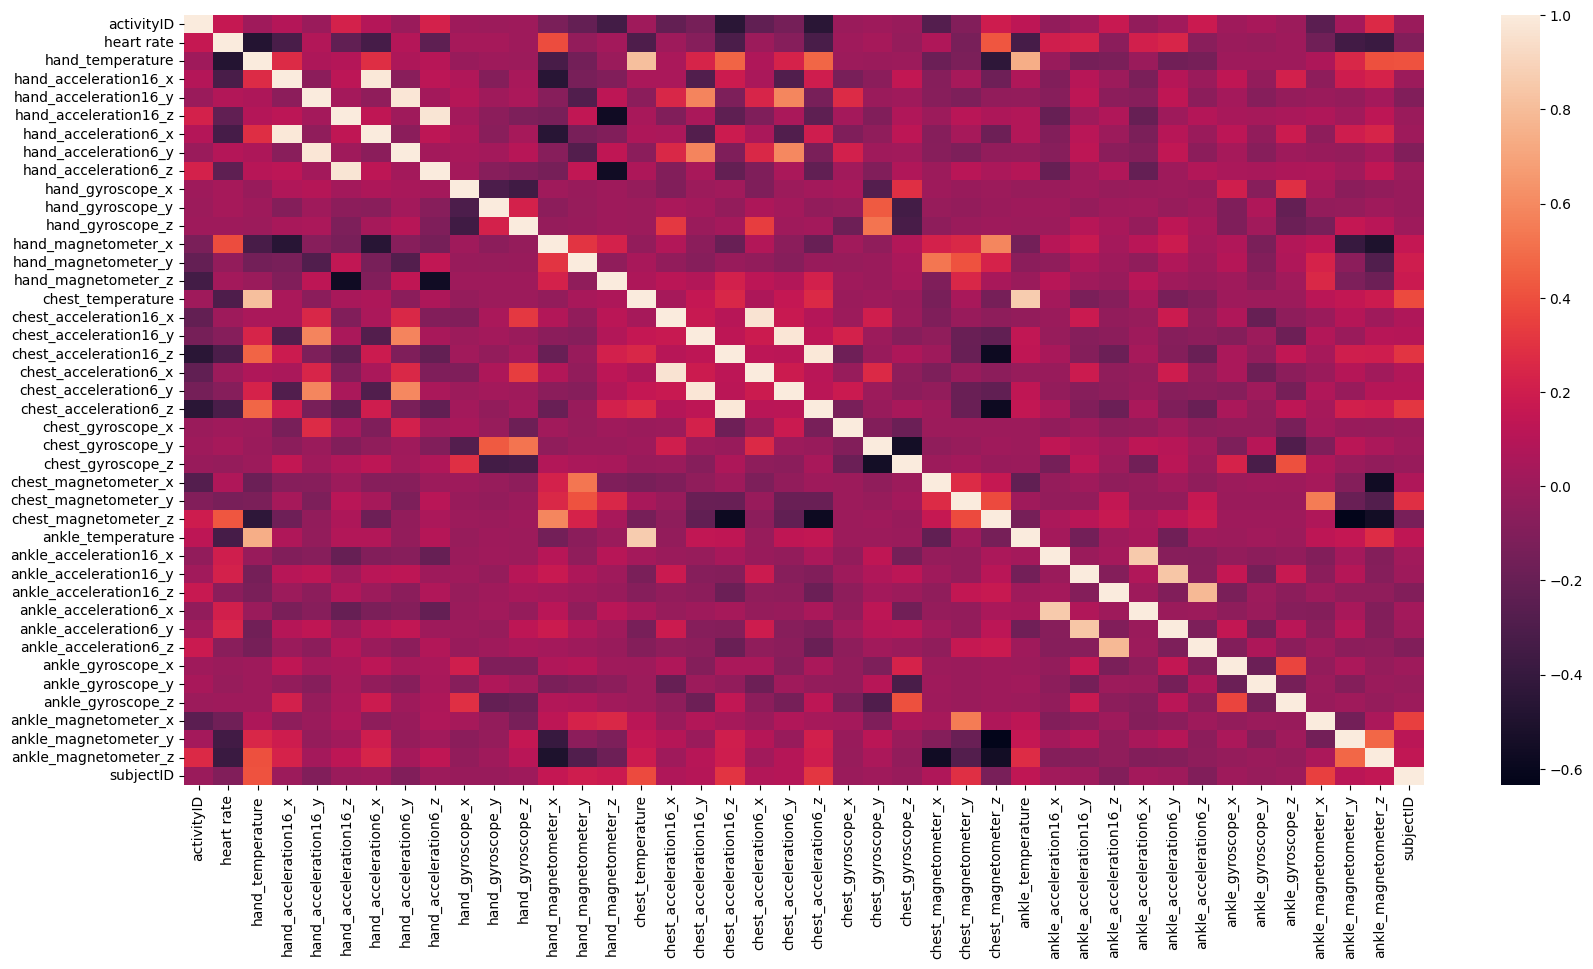

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
sns.heatmap(df_train.corr())

In [7]:
drop_thr = 0.5

corr_arr = np.tril(np.abs(np.array(df_train.corr()) - np.eye(df_train.corr().shape[0])))
cols_to_drop = [col for col, maxcorr in zip(df_train.columns, corr_arr.max(axis=1)) if maxcorr > drop_thr]
cols_to_drop

['hand_acceleration6_x',
 'hand_acceleration6_y',
 'hand_acceleration6_z',
 'hand_magnetometer_z',
 'chest_temperature',
 'chest_acceleration16_y',
 'chest_acceleration6_x',
 'chest_acceleration6_y',
 'chest_acceleration6_z',
 'chest_gyroscope_y',
 'chest_gyroscope_z',
 'chest_magnetometer_x',
 'chest_magnetometer_z',
 'ankle_temperature',
 'ankle_acceleration6_x',
 'ankle_acceleration6_y',
 'ankle_acceleration6_z',
 'ankle_magnetometer_x',
 'ankle_magnetometer_y',
 'ankle_magnetometer_z']

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
# pipe = make_pipeline(StandardScaler())
X_train = pipe.fit_transform(df_train.drop(columns=['activityID', 'subjectID'] + cols_to_drop))
y_train = df_train['activityID']

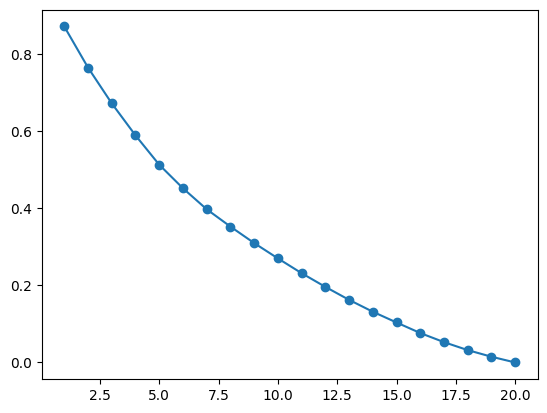

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_for_dimention_selection = PCA(n_components=X_train.shape[1])
pca_for_dimention_selection.fit(X_train)
explained_variance_cumsum = pca_for_dimention_selection.explained_variance_.cumsum()
explained_variance_sum = pca_for_dimention_selection.explained_variance_.sum()
plt.plot(range(1, explained_variance_cumsum.shape[0] + 1),
         (explained_variance_sum - explained_variance_cumsum) / explained_variance_sum,
         marker='o')

In [10]:
pipe = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler(), PCA(n_components=15))
X_train = pipe.fit_transform(df_train.drop(columns=['activityID', 'subjectID'] + cols_to_drop))
y_train = df_train['activityID']

In [11]:
from sklearn.cluster import KMeans


param_grid = {
    'n_clusters': list(range(2, 8)),  # тут нужно осмысленно выборать параметры
    'n_init': [10]
}
grid_search = GridSearchCV(KMeans(), param_grid, cv=5, scoring='adjusted_mutual_info_score')

In [12]:
grid_search.fit(X_train, y_train)
print(grid_search.best_score_, '\n', print(grid_search.best_params_))

{'n_clusters': 7, 'n_init': 10}
0.4943074101592776 
 None


In [13]:
full_model = KMeans(**grid_search.best_params_).fit(X_train, y_train)
clusters = full_model.predict(X_train)

# classif

In [14]:
X_train = df_train.drop(columns=['activityID', 'subjectID'])
X_train['cluster'] = clusters
y_train = df_train['activityID']

In [15]:
from lightgbm import LGBMClassifier

In [16]:
param_grid = {
    'reg_lambda': [10, 50, 100, 300],
    'max_depth': [3, 5, 10]
}
grid_search = GridSearchCV(LGBMClassifier(), param_grid, cv=5, scoring='roc_auc_ovo')
grid_search.fit(X_train, y_train)
grid_search.best_score_, grid_search.best_params_ 

(0.9752035760720126, {'max_depth': 10, 'reg_lambda': 300})

In [42]:
model = LGBMClassifier(**grid_search.best_params_).fit(X_train, y_train)


In [43]:
X_test = df_test.drop(columns=['activityID', 'subjectID'])
X_test['clusters'] = full_model.predict(
    pipe.transform(df_test.drop(columns=['activityID', 'subjectID'] + cols_to_drop))
)
y_test = df_test['activityID']

In [44]:
from sklearn.metrics import roc_auc_score

preds = model.predict_proba(X_test)
train_preds = model.predict_proba(X_train)
print(roc_auc_score(y_test, preds, multi_class='ovo'), roc_auc_score(y_train, train_preds, multi_class='ovo'))

0.96063523146096 0.9999999746020052


In [45]:
from sklearn.metrics import accuracy_score

preds = model.predict_proba(X_test).argmax(axis=1)
train_preds = model.predict_proba(X_train).argmax(axis=1)

print(accuracy_score(y_test, preds), accuracy_score(y_train, train_preds))

0.777740601046356 0.9998398132680382


In [46]:
model.predict_proba(X_test[:2]), y_test[:2]

(array([[0.06505968, 0.04860494, 0.00449979, 0.00335468, 0.87848091],
        [0.21580822, 0.04149489, 0.00384155, 0.00286395, 0.73599139]]),
 2134    0
 2135    0
 Name: activityID, dtype: int64)

In [47]:
model.predict_proba(X_test[-2:]), y_test[-2:]

(array([[0.01111154, 0.01726607, 0.90145681, 0.06458315, 0.00558244],
        [0.00891142, 0.01728707, 0.90255351, 0.06565877, 0.00558923]]),
 176601    2
 176602    2
 Name: activityID, dtype: int64)

In [48]:
preds = model.predict_proba(X_test).argmax(axis=1)
confusion = np.empty((len(set(y_test)), len(set(preds))))
df_conf = pd.DataFrame({'true': y_test, 'pred': preds})
for true_label in set(y_test):
    for pred_label in set(preds):
        confusion[true_label, pred_label] = ((df_conf.true == true_label) & (df_conf.pred == pred_label)).sum()
np.set_printoptions(suppress=True)
print(confusion)

[[4944.    5.    0.    0.  376.]
 [ 907. 7374.    0.    7.    9.]
 [ 158.  161. 2470. 1060.    0.]
 [ 148.  370.    2. 5750.    3.]
 [3465.  636.    0.    0. 5031.]]


In [49]:
y_test.value_counts()

activityID
4    9132
1    8297
3    6273
0    5325
2    3849
Name: count, dtype: int64

# pickling

In [32]:
import pickle 

In [54]:
with open('../pickles/pipe.pkl', 'wb') as pipe_file:
    pickle.dump(pipe, pipe_file)

with open('../pickles/boosting_model.pkl', 'wb') as bst_file:
    pickle.dump(model, bst_file)

with open('../pickles/clustering_model.pkl', 'wb') as clust_file:
    pickle.dump(full_model, clust_file)

In [56]:
str(cols_to_drop)

"['hand_acceleration6_x', 'hand_acceleration6_y', 'hand_acceleration6_z', 'hand_magnetometer_z', 'chest_temperature', 'chest_acceleration16_y', 'chest_acceleration6_x', 'chest_acceleration6_y', 'chest_acceleration6_z', 'chest_gyroscope_y', 'chest_gyroscope_z', 'chest_magnetometer_x', 'chest_magnetometer_z', 'ankle_temperature', 'ankle_acceleration6_x', 'ankle_acceleration6_y', 'ankle_acceleration6_z', 'ankle_magnetometer_x', 'ankle_magnetometer_y', 'ankle_magnetometer_z']"

In [62]:
with open('../pickles/dropcols.txt', 'w') as cols_file:
    cols_file.write(', '.join(cols_to_drop))

In [63]:
with open('../pickles/dropcols.txt', 'r') as cols_file:
    s = cols_file.read()
print(s)

hand_acceleration6_x, hand_acceleration6_y, hand_acceleration6_z, hand_magnetometer_z, chest_temperature, chest_acceleration16_y, chest_acceleration6_x, chest_acceleration6_y, chest_acceleration6_z, chest_gyroscope_y, chest_gyroscope_z, chest_magnetometer_x, chest_magnetometer_z, ankle_temperature, ankle_acceleration6_x, ankle_acceleration6_y, ankle_acceleration6_z, ankle_magnetometer_x, ankle_magnetometer_y, ankle_magnetometer_z
